In [2]:
from dataclasses import dataclass
from datetime import datetime
import os
import dotenv
import pandas as pd

dotenv.load_dotenv()
db_url = os.getenv("DB_URL")
from sqlalchemy import select
from defi_common.dbconfig import db_config

db_config.db_url = db_url
from defi_common.database.db import async_session
from defi_common.database.models import CoinChangeRank


In [29]:

from typing import List
from defi_common import data
from defi_common.database.services import async_find_address
from defi_common.database.models import AggregatedBalanceUpdate, Address


@dataclass
class CoinRank:
    symbol: str
    rank: int
    time_created: datetime


@dataclass
class AssetBalance:
    symbol: str
    time: datetime
    amount: float
    value_pct: float


async def get_address_balance_of_coin_historically(address: str, coin_symbol: str) -> \
        List[AssetBalance]:
    async with async_session() as ses:
        address_input = data.Address(address=address)
        address_model = await async_find_address(address_input, ses)
        sel = select(AggregatedBalanceUpdate) \
            .where(AggregatedBalanceUpdate.address_id == address_model.id,
                   AggregatedBalanceUpdate.symbol == coin_symbol) \
            .order_by(AggregatedBalanceUpdate.time.desc())
        exec = await ses.execute(sel)
        result = exec.scalars().all()
        return [AssetBalance(symbol=balance.symbol,
                             amount=balance.amount,
                             time=balance.time,
                             value_pct=balance.value_pct)
                for balance in result]




In [30]:
result_parsed = await get_address_balance_of_coin_historically(
    address="0x26fcbd3afebbe28d0a8684f790c48368d21665b5", coin_symbol="ETH")

                    symbol      amount  value_pct
time                                             
2023-01-22 00:00:00    ETH   14.079267  16.988591
2023-01-21 23:45:00    ETH   14.079267  16.971958
2023-01-21 23:30:00    ETH   14.079267  16.936590
2023-01-21 23:15:00    ETH   14.079267  16.938253
2023-01-21 23:00:00    ETH   14.079267  16.912213
...                    ...         ...        ...
2022-12-29 02:00:00    ETH  642.741005  54.416572
2022-12-29 01:50:00    ETH  642.741005  54.421649
2022-12-29 01:40:00    ETH  642.741005  54.404229
2022-12-29 01:30:00    ETH  642.741005  54.402627
2022-12-29 01:20:00    ETH  642.741005  54.395600

[2283 rows x 3 columns]


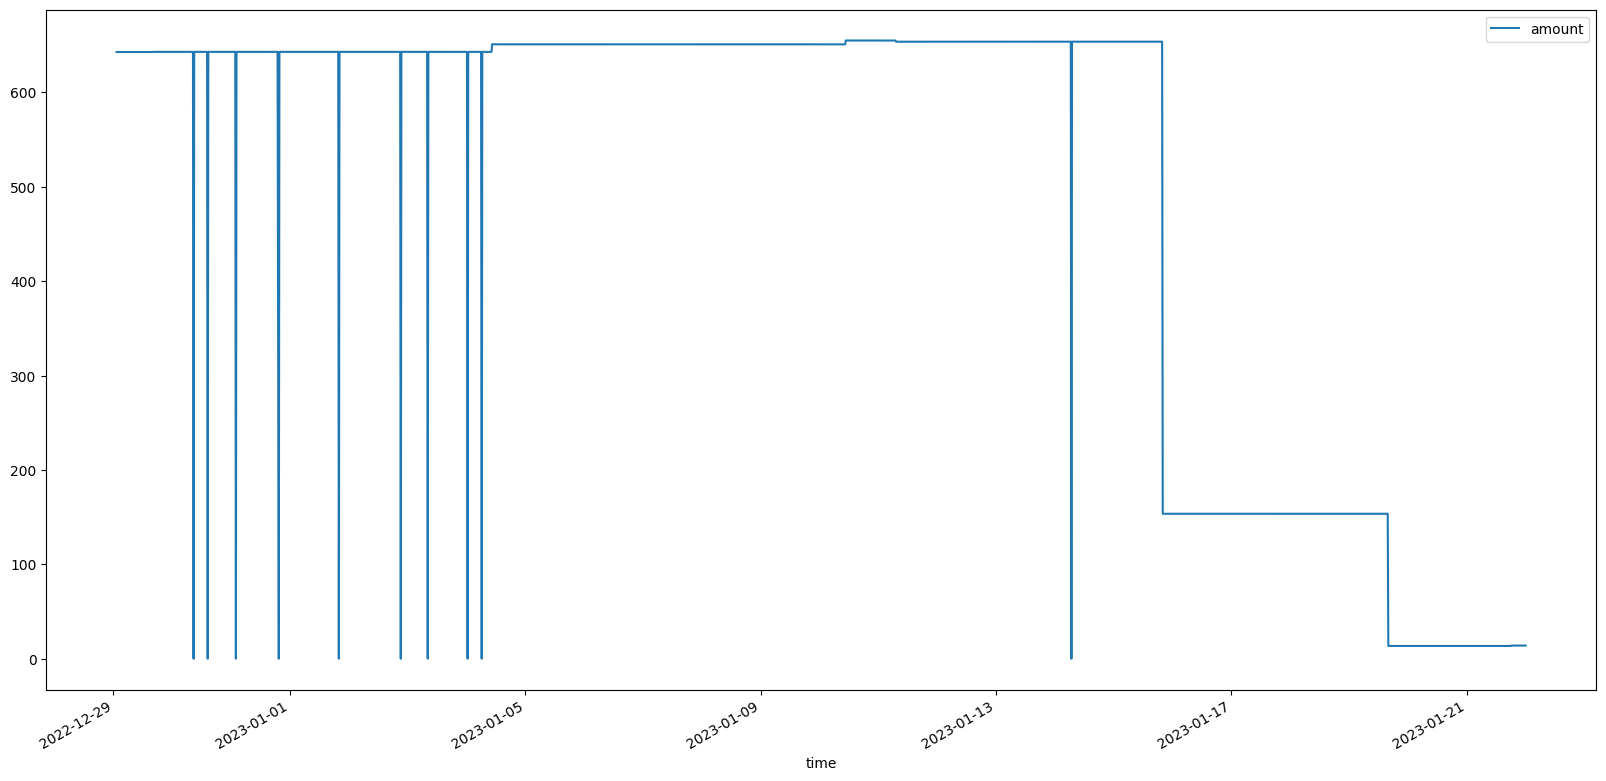

In [40]:
df = pd.DataFrame(result_parsed)
df = df.set_index("time")
big = df[df['amount'] > 600]
# print(big.head(50))
# print(len(big)/len(df))
print(df)
df.plot(y="amount", figsize=(20, 10))
df.to_csv("./export.csv")